In [23]:
import pymongo
import pandas as pd
import numpy as np
import datetime
import dateutil
import csv

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm 

In [80]:
file_names=['conference_room.csv', 'lab_room.csv', 'kitchen_room.csv']
#file_names=['conference_room.csv']
anchor_name=["raspberrypi"+str(i) for i in range(1, 13)]
minor='41'
test_time=10

#Format: train_data[room index, x, y, direction]=list of training data from all the anchors
# Format: test_data[room index, x, y, direction]=list of testing data from all the anchors
train_data={}
test_data={}

for i in range(len(file_names)):
    file=file_names[i]
    print("Extract data for:", file)
    df=pd.read_csv(file, sep=',')
    test_info=np.array(df)
    
    df_samples=[]
    # extract data for all the anchors
    for anchor in anchor_name:
        current_df_sample=pd.read_csv('./fingerprint/'+anchor+'_'+minor+'_'+file, sep=',')
        df_samples.append(current_df_sample)
        
        
    for j in range(int(len(test_info)/2)):
        x=test_info[j*2][2]
        y=test_info[j*2][3]
        direction=test_info[j*2][4]
        rssi_pi=[]
        time_pi=[]
        for data in df_samples:
            # Save data for all the anchors
            rssi_pi.append(np.array(data[(data['x']==x) & (data['y']==y) & (data['direction']==direction)]['RSSI'])[::-1])
            time_pi.append(np.array(data[(data['x']==x) & (data['y']==y) & (data['direction']==direction)]['time'])[::-1])


        test_end_time=np.max([dateutil.parser.parse(time[-1]) for time in time_pi if len(time)!=0])
        test_start_time=test_end_time-datetime.timedelta(seconds=test_time)
        #print(x, y, direction,end_time)

        current_train_data=[]
        current_test_data=[]
    
        # len(rssi_pi) = number of anchors
        for k in range(len(rssi_pi)):
            current_time=np.array([dateutil.parser.parse(time) for time in time_pi[k]])
            current_test_data.append(list(rssi_pi[k][current_time>=test_start_time]))
            current_train_data.append(list(rssi_pi[k][current_time<test_start_time]))

        test_data[i, x, y, direction]=current_test_data
        train_data[i, x, y, direction]=current_train_data
        
    

Extract data for: conference_room.csv
Extract data for: lab_room.csv
Extract data for: kitchen_room.csv


In [16]:
# Generate training and testing data for the room-level classification
train_x=[]
train_y=[]

test_x=[]
test_y=[]

for key in train_data:    
    train_x.append([np.median(data) if len(data)!=0 else -100 for data in train_data[key]])
    test_x.append([np.median(data) if len(data)!=0 else -100 for data in test_data[key]])
    train_y.append(key[0])
    test_y.append(key[0])
    

In [81]:
# room level detection
# consider all the anchors
k_candidate=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#k_candidate=[1]
accuracy=[]
for k in k_candidate:
    predict_y=[]
    neigh_room = KNeighborsClassifier(n_neighbors=k)
    neigh_room.fit(np.array(train_x), np.array(train_y))
    for test_rssi in test_x:
        predict_y.append(neigh_room.predict([test_rssi])[0])
    print(k, np.sum(np.array(test_y)==np.array(predict_y))/len(test_y))
    accuracy.append(np.sum(np.array(test_y)==np.array(predict_y))/len(test_y))

1 0.9463087248322147
2 0.9211409395973155
3 0.9161073825503355
4 0.9144295302013423
5 0.9060402684563759
6 0.9026845637583892
7 0.8942953020134228
8 0.8993288590604027
9 0.8942953020134228
10 0.8993288590604027


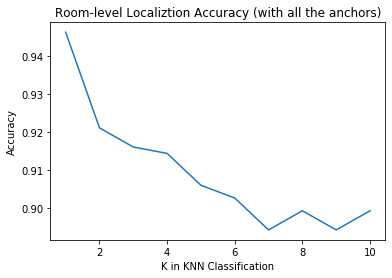

In [86]:
import matplotlib.pyplot as plt
plt.plot(k_candidate, accuracy)
plt.xlabel("K in KNN Classification")
plt.ylabel("Accuracy")
plt.title("Room-level Localiztion Accuracy (with all the anchors)")
plt.show()

In [91]:
# room level detection
# consider the strongest k_anchor rssi 
k_candidate=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k_anchor=3

accuracy=[]
for k in k_candidate:
    predict_y=[]
    for test_rssi in test_x:
        anchor_index=np.argsort(np.array(test_rssi))[:-(k_anchor+1):-1]
        #print(np.argsort(np.array(test_rssi)))
        neigh_room = KNeighborsClassifier(n_neighbors=k)
        neigh_room.fit(np.array(train_x)[:,anchor_index], np.array(train_y))
        predict_y.append(neigh_room.predict([np.array(test_rssi)[anchor_index]])[0])
        
    print(k, np.sum(np.array(test_y)==np.array(predict_y))/len(test_y))
    accuracy.append(np.sum(np.array(test_y)==np.array(predict_y))/len(test_y))

1 0.7751677852348994
2 0.7550335570469798
3 0.7701342281879194
4 0.7768456375838926
5 0.7835570469798657
6 0.7885906040268457
7 0.802013422818792
8 0.8003355704697986
9 0.8104026845637584
10 0.7969798657718121


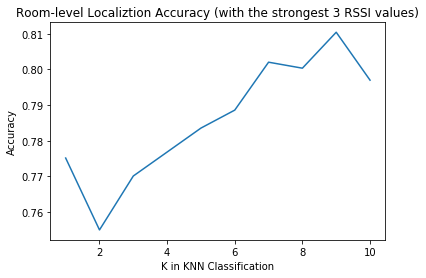

In [92]:
plt.plot(k_candidate, accuracy)
plt.xlabel("K in KNN Classification")
plt.ylabel("Accuracy")
plt.title("Room-level Localiztion Accuracy (with the strongest 3 RSSI values)")
plt.show()